# QA simulation of vacancies in graphene explained

## The model

In this tutorial, we are going to use a simple model to calculate the energy of vacancies in graphene.

**The material**

The chemical system we are going to study is a graphene sheet. In order to be able to calculate the energy of up to three vacancies, we are going to use a 3x3 supercell of the primitive cell.

Let's first build the system. For this task we are going to be using a python library called pymatgen. pymatgen is a very powerful tool developed as part of the Materials Project. It can be used to create, modify, analyse 3D systems. Don't worry if you are not familiar with pymatgen, we are only going to use it to generate the structure and every step is explained.

First we need to import the two objects that we are going to use to generate the graphene structure, which is called Structure:

In [1]:
from pymatgen.core.structure import Structure

We are going to use numpy to define the lattice as a 3x3 matrix:

In [2]:
import numpy as np

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

The Structure object requires three pieces on informations: the lattice, the species and the fractional coordinates of these species in the cell defined by lattice. So, we are going to create and inspect what information is in the graphene object by displaying it.

In [3]:
graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
display(graphene)

Structure Summary
Lattice
    abc : 2.4677242827325747 2.4677242827325747 8.685038
 angles : 90.0 90.0 120.00000758003493
 volume : 45.80317575176706
      A : 1.233862 -2.137112 0.0
      B : 1.233862 2.137112 0.0
      C : 0.0 0.0 8.685038
PeriodicSite: C (1.2339, -0.7124, 0.0000) [0.6667, 0.3333, 0.0000]
PeriodicSite: C (1.2339, 0.7124, 0.0000) [0.3333, 0.6667, 0.0000]

The supercell can be created by using the pymatgen make_supercell function. First we need to define the expansion matrix:

In [4]:
import copy 

expansion_matrix = np.array([[3, 0, 0],
                            [0, 3, 0],
                            [0, 0, 1]])

graphene_supercell = copy.deepcopy(graphene)

graphene_supercell.make_supercell(expansion_matrix)

display(graphene_supercell)

Structure Summary
Lattice
    abc : 7.403172848197724 7.403172848197724 8.685038
 angles : 90.0 90.0 120.00000758003493
 volume : 412.2285817659035
      A : 3.701586 -6.411336 0.0
      B : 3.701586 6.411336 0.0
      C : 0.0 0.0 8.685038
PeriodicSite: C (1.2339, -0.7124, 0.0000) [0.2222, 0.1111, 0.0000]
PeriodicSite: C (2.4677, 1.4247, 0.0000) [0.2222, 0.4444, 0.0000]
PeriodicSite: C (3.7016, 3.5619, 0.0000) [0.2222, 0.7778, 0.0000]
PeriodicSite: C (2.4677, -2.8495, 0.0000) [0.5556, 0.1111, 0.0000]
PeriodicSite: C (3.7016, -0.7124, 0.0000) [0.5556, 0.4444, 0.0000]
PeriodicSite: C (4.9354, 1.4247, 0.0000) [0.5556, 0.7778, 0.0000]
PeriodicSite: C (3.7016, -4.9866, 0.0000) [0.8889, 0.1111, 0.0000]
PeriodicSite: C (4.9354, -2.8495, 0.0000) [0.8889, 0.4444, 0.0000]
PeriodicSite: C (6.1693, -0.7124, 0.0000) [0.8889, 0.7778, 0.0000]
PeriodicSite: C (1.2339, 0.7124, 0.0000) [0.1111, 0.2222, 0.0000]
PeriodicSite: C (2.4677, 2.8495, 0.0000) [0.1111, 0.5556, 0.0000]
PeriodicSite: C (3.7016, 4.9

Please find below an image of the supercell where the atom index has been reported on the atom itself.

[graphene_primitive_cell](images/graphene_primitive_cell.png)

As a note for non experts in materials science, the cell reported here has 2-dimensional periodicity, also called periodic boundary conditions. This means it is repeated periodically, effectively representing an infinite graphene sheet. The image below shows a 3x3 supercell of the graphene supercell used in this notebook. 

[graphene_super_cell](images/graphene_super_cell.png)

This is going to become relevant later in the definition of the model.

From the graphene_supercell structure displayed above, you can see the structure now containins 18 atoms and the lattice parameters a and b are three times as large as the primitive cell ones.

Now, let's start defining the vectors and matrices that we will use to represent the system.
First we are going to create the vector **c**. This is the vector that we are going to use to identify atom positions in the system. It will contain, therefore, numbers from 0 to the total number of atoms:

In [5]:
c = np.arange(graphene_supercell.num_sites)
display(c)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

To do so, we used the numpy arange function and the num_sites attribute of the graphene_supercell Structure object to define the upper bound.

We are also going to define the vector **x**. This is a binary vector where:
- $x_{i}$ = 1 if atom i is present
- $x_{i}$ = 0 if atom i has been replaced by a vacancy

At first we are going to define the structure containing no vacancies, so $x_{i}$ = 1 for all $i$

In [6]:
x = np.array([1]*graphene_supercell.num_sites)
display(x)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Because in the model we are using, the energy depends on the number of bonds, we need a way to identify bonded atoms. To do so, we are going to start with the distance_matrix, which is a property of the graphene_supercell object:

In [7]:
graphene_sc_distance_matrix = graphene_supercell.distance_matrix
display(graphene_sc_distance_matrix)

array([[0.        , 2.46772428, 2.46772428, 2.46772428, 2.467724  ,
        4.27422351, 2.46772428, 4.27422351, 2.467724  , 1.42474133,
        3.769511  , 1.42474117, 1.42474117, 2.84948234, 2.84948267,
        3.769511  , 3.7695107 , 2.84948234],
       [2.46772428, 0.        , 2.46772428, 4.27422351, 2.46772428,
        2.467724  , 2.467724  , 2.46772428, 4.27422351, 1.42474117,
        1.42474133, 3.769511  , 2.84948267, 1.42474117, 2.84948234,
        2.84948234, 3.769511  , 3.7695107 ],
       [2.46772428, 2.46772428, 0.        , 2.467724  , 4.27422351,
        2.46772428, 4.27422351, 2.467724  , 2.46772428, 3.769511  ,
        1.42474117, 1.42474133, 2.84948234, 2.84948267, 1.42474117,
        3.7695107 , 2.84948234, 3.769511  ],
       [2.46772428, 4.27422351, 2.467724  , 0.        , 2.46772428,
        2.46772428, 2.46772428, 2.467724  , 4.27422351, 3.769511  ,
        3.7695107 , 2.84948234, 1.42474133, 3.769511  , 1.42474117,
        1.42474117, 2.84948234, 2.84948267],
    

In graphene_sc_distance_matrix, the element in position $i,j$ is the distance (in Å) between atom $i$ and atom $j$.

Next we will create a list of unique distances contained in the graphene_sc_distance_matrix to identify the number of "shells" an atom has. We will do so by using numpy:

shells = np.unique(distance_matrix_pbc[0])
display(shells)

In [8]:
shells = np.unique(np.round(graphene_sc_distance_matrix[0],5)) 
display(shells)

array([0.     , 1.42474, 2.46772, 2.84948, 3.76951, 4.27422])

In this model, we are only interested in the nearest neighbours, i.e. the ones in the first coordination shell, which corresponds to the element in position 1 of the array above (remember that in python we start counting from 0). Therefore, we can combine the information contained in the graphene_sc_distance_matrix and shells arrays to generate the adjacency matrix:

In [9]:
adjacency_matrix = (np.round(graphene_sc_distance_matrix,5) == shells[1]).astype(int)
display(adjacency_matrix)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In adjacency_matrix:
- the element in position $i,j$ = 1 if atoms $i$ and $j$ are bonded
- the element in position $i,j$ = 0 if atoms $i$ and $j$ are not bonded

We can verify this for the atom 0. Let's look at the position of the 1s in the first line of the adjacency_matrix:

In [10]:
np.where(adjacency_matrix[0] == 1)[0]

array([ 9, 11, 12])

We can see that atom 0 is bound to atoms 9, 11 and 12. This is confirmed by looking at the image above, where we can see that atoms 9 and 11 are next to atom 0. Atom 12 is at the other end of the cell and this is where the periodic boundary conditions (or 2D periodicity is included in the model). By saying that atom 0 and 12 are bonded, we are saying that once we get to the end of the cell, we start back from the opposite side (explain better).

## Classical approach

What is meant by "Classical approach" is that we are going to follow the usual workflow in computational materials chemistry:

- define the system
- define the model used to describe the model
- define the model used to calculate the energy of the system
- calculate the energy

The system and the model to represent it were described above in terms of **c** and **x** vectors and the **adjacency_matrix**.

We are going to start by defining a very simple model to calculate the energy of the system:

- each bond decreases the energy by 1 a.u. (arbitrary unit)

Therefore, the task will be finding out how many bonds there are in the system. 

A very simple way to achieve this would be counting how many 1s there are in the adjacenty_matrix and divide that number by two because this procedure counts the bond between $i$ and $j$ and the bond between $j$ and $i$ as two separate bonds. Let's see how we could do this:

In [11]:
num_bonds = np.sum(adjacency_matrix)/2
display(num_bonds)

27.0

The above described procedure works well if there are no vacancies in the system. Let's think about a way to describe systems with vacancies.

We are going to start by multiplying the **x** vector by the **adjacency_matrix** and call this intermediate result **r**:

In [12]:
r = np.matmul(x,adjacency_matrix)
display(r)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

The vector **r** has length number of atoms in the supercell. The element $r_{i}$ tell us how many atoms the atom $i$ is bonded to.

Now we are going to multiply $\bf x^{T}$ by **r** and multiply by -1 and divide the final result by 2 to obtain the energy:

In [13]:
E = -0.5 * np.matmul(x,r)
display(E)

-27.0

### 1 vacancy

Let's now simulate systems with 1 vacancy. At first we will introduce the vacancy in position 0. To achieve this, we will replace the 1 in position 0 of the x vector by a 0:

In [14]:
x[0] = 0
display(x)

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

We will calculate the energy of the system following the same procedure used above, but this time we will perform both steps at once:

$$
E = - 0.5 \  \bf x^{T} * \ adjacency\_matrix * \ x
$$

In [15]:
E = - 0.5 * np.matmul(x,np.matmul(x,adjacency_matrix))
display(E)

-24.0

As expected, one vacancy removes 3 bonds and, therefore, the energy went up by 3 a.u.

Because of the symmetry of the system and the way the model is built, all atom positions are equivalent. This means that a vacancy in any position will increase the energy by 3 a.u., but let's confirm this.

Let's build a matrix, called **X**, where each row represents a possible position for the vacancy:

In [16]:
X = np.array([[1]*graphene_supercell.num_sites]*graphene_supercell.num_sites)
np.fill_diagonal(X,0)

In [17]:
X

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In the **X** matrix, the row $i$ represents the configuration with the vacancy in the $i-th$ position.

We could now procede to calculate the energy of each configuration using a for loop, i.e. multiply each line by the adjacency_matrix and then again by the transposed line. Let's do this in the cell below and use a faster approach later:

In [18]:
energies = []
for line in X:
    energies.append(np.matmul(line, np.matmul(line, adjacency_matrix)))

display(energies)

[48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48]

As expected, the energy if the same for each configuration. In the **energies** vector above, the element $e_i$ is the energy of the configuration $i$.

The faster approach mentioned above consists in using linear algebra knowledge and multiply the **X** matrix by the **adjacency_matrix** directly:

In [19]:
#REVIEW THIS
energies = - np.matmul(X,adjacency_matrix)
energies = np.sum(adjacency_matrix,axis = 1)
display(energies)

#E_tmp = -np.matmul(X_classical,adjacency_matrix)
#E_classical = np.sum(X_classical*E_tmp,axis=1)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

The energy landscape as a function of the configuration is plotted below. The configuration index can be seen as representing in which position the vacancy is located, i.e. configuration 1 corresponds to
```
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
```

Notice that the energy of all structures is -48 a.u. This will change when we introduce more vacancies (see below).

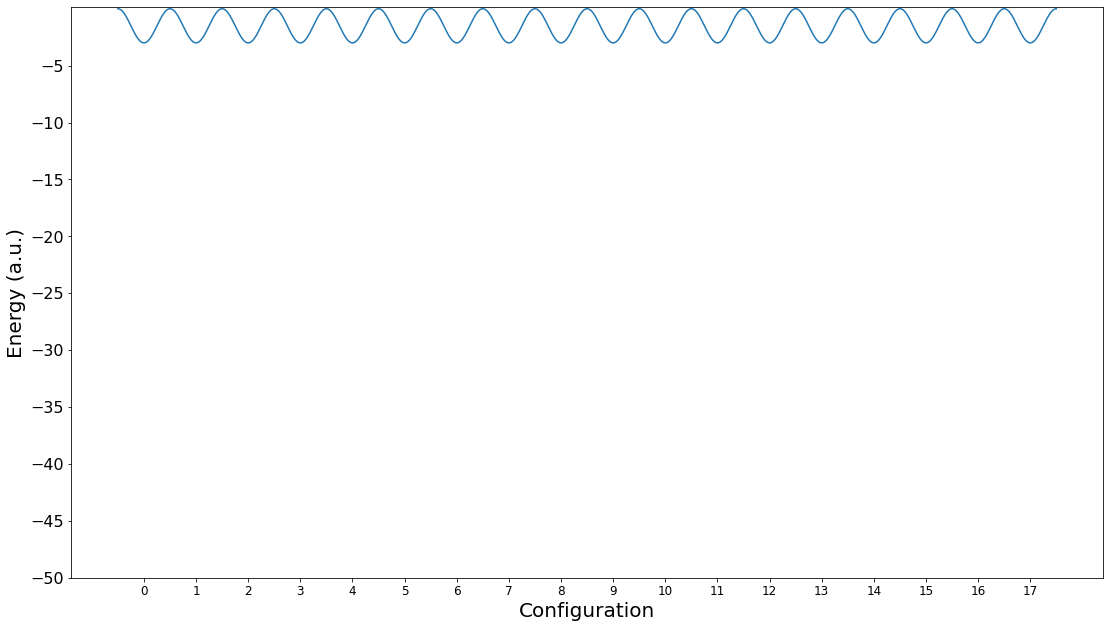

In [20]:
import matplotlib.pyplot as plt

font = {'size'   : 14.5,
       'weight': 'normal'}

plt.rc('font', **font)

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

x = np.arange(-.5,17.5,0.001)
y = (energies[0]/2)*np.cos((2*x+1)*np.pi)-(energies[0]/2)

ax.plot(x,y)

ax.set_xlabel('Configuration', fontsize=20)
ax.set_ylabel('Energy (a.u.)', fontsize=20) 
ax.set_ybound()

ax.set_xticks(np.arange(0,18))
ax.set_yticks(np.arange(-50,0,5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

fig.set_size_inches(18.5, 10.5)

plt.show()

### All possible configurations

As the final step of this "classical approach", we are going to calculate the energy of all possible configurations and number of vacancies. There will be $2^{num_atoms}$, so $2^{18} = 262144$ possible configurations. The new **X** matrix that contain all of them will be generated by using a python module called itertools. The first 10 configurations are displayed below.

In [21]:
import itertools
X = np.array(list(itertools.product([0, 1], repeat=18)))
X[0:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]])

Now we are going to use the same approach discussed above to calculate the energy of all the configurations. 

In [22]:
energies = - np.sum(X*np.matmul(X,adjacency_matrix), axis=1)
energies

array([  0,   0,   0, ..., -48, -48, -54])

Let's now have a look at the unique energies for the set:

In [23]:
energies_unique, count = np.unique(energies, return_counts=True)
display(energies_unique)
display(count)

array([-54, -48, -44, -42, -40, -38, -36, -34, -32, -30, -28, -26, -24,
       -22, -20, -18, -16, -14, -12, -10,  -8,  -6,  -4,  -2,   0])

array([    1,    18,    27,   126,    54,   324,   564,   729,  1728,
        2367,  4023,  6048,  8757, 12204, 16686, 20454, 25542, 28701,
       30276, 30402, 26919, 21267, 14904,  7425,  2598])

In the cell above, the first array reports the unique energies, whereas, the second one reports how many structures corresponding to a certain energies were found.

## Coordination energy

In this section we are going to refine the model described above by adding an extra term to the function that calculates the energy. The model used so far is very efficient in calculating the number of broken bonds. 

However, ask any chemist or material scientist and they will tell you this is not enought to discriminate between same energy structures. 

For example, the image below reports two structures, both containing two vacancies. As you can see, they both have XXX broken bonds and, therefore, the model discussed above calculates the same energy value of XXX au. XXX

We can go one step further by starting to think of undercoordinated atoms. We know that the more uncoordinated an atom is, the more unstable it is going to be.

# Quantum annealing

In this section we are going to use a quantum annealer to find the lowest energy/energies structures for a certain configuration.

This approach, opposite to the "classical approach", will consist of:

- define the system 
- define the model to represent the system
- encode both the model to represent the system and the energy model into a binary quadratic model (explain below)
- run the annealing N times and analyse the results (energy and configuration)

The important difference to notice with respect to the "Classical model" is that instead of defining the model to represent the system, we are encoding that information into the binary quadratic model that, by trying to find the lowest energy solution, will return both the energy of the system and the corresponding configuration. Therefore, we are still going to use the **c** vector, but the **x** vectors will be returned by the calculation.

### The Binary Quadratic Model

The binary quadratic model can be expressed as:

$$
E = \sum_{i} h_{i} x_{i} + \sum_{i,j} J_{i,j} x_{i}x_{j}
$$

where, in the context of quantum annealing computing:

- $h_i$ is called bias 
- $J_{i,j}$ is called coupling

The bias corresponds to the magnetic fiels applied to the qubit that will make the spin up or spin down more or less favourable. The coupling is the stringth that will be applied between qubits to make them end up in the same/opposite state (EXPLAIN BETTER).

We can think of representing the $h_{i}$ and $J_{i,j}$ as a matrix, where the $h_{i}$ are the diagonal elements and the $J_{i,j}$ the off diagonal elements. This is usually referred to as a QUBO (Quadratic Unconstrained Binary Optimisation):

$$
E({\bf x}) =  {\bf x^{T}}\ {\bf Q}\ {\bf x} = \sum_{i} Q_{i,i} x_{i} + \sum_{i} \sum_{j > i} Q_{i,j} x_{i}x_{j}
$$

where: 
- ${\bf Q}$ is the QUBO matrix. This matrix defines the problem. It needs, therefore, to encode the problem itself. This is where the quantum annealing algorithm developers will dedicate their efforts.
- ${\bf x}$ is the binary vector, returned by the quantum annealer, that corresponds to $E({\bf x})$.

Minimise the energy


**The quantum annealing for quantum chemists/material scientists workflow**

Let's see what are the steps the quantum chemists/materials scientists need to take in order to run their simulations on a quantum annealer.

XXX

### Binary Quadratic Model for graphene 

Let's start building the binary quadratic model for the graphene 3x3 supercell. We will use the c vector as defined above:

In [24]:
display(c)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

This time we will not define the x vectors, because it will be returned by the quantum annealer. However, we need to encode the problem in the $h_i$ and $J_{i,j}$ terms. So let's see how that translates:

- the energy only depends on the presence of the bonds
- if the $x_i$ element of the ${\bf x}$ vector is one, it means the atom is present (viceversa for 0)
- if atom $i$ and atom $j$ are nearest neighbours and they are both present, the energy of the system decreases by 1 a.u.

With this in mind we can say:

- $h_i$ = 0 for each i. This is because the energy of the system only depends on the presence of the bond, which is a 2 atom property
- $J_{i,j}$ = -1 if atom $i$ and atom $j$ are nearest neighbours, 0 otherwise

If you recall, the definition of the adjacency_matrix is that $J_{i,j}$ = 1 if atom $i$ and atom $j$ are nearest neighbours, 0 otherwise. We can, therefore, use the -adjacency_matrix to build the model. 

The **objective** is minimising the following expression:

$$
\sum_{i}^{N_{atoms}}\sum_{j>i}^{N_{atoms}} -A_{i,j} x_{i} x_{j}
$$

Since the adjacency_matrix is already a matrix itself, we will use the QUBO formulation of the problem.

D-Wave systems offers a comprehensive library (dimod) to build binary quadratic models. In the cell below we will import the BinaryQuadraticModel class from dimod.

We then procede to building the QUBO matrix ${\bf Q}$. We use the numpy triu function that selects the top right handside part of the adjacency_matrix. This is because we don't want to double count the bonds. 

Finally, we generate the BinaryQuadraticModel from the ${\bf Q}$ matrix by using the .from_qubo command. 

In [25]:
from dimod import BinaryQuadraticModel

Q = np.triu(-adjacency_matrix.astype(int),0)

bqm = BinaryQuadraticModel.from_qubo(Q)

An interesting feature of the bqm object is that you can inspect it. For example, it can be transformed into Numpy vectors and from there the linear and quadratic biases exhamined:

In [26]:
bqm.to_numpy_vectors().linear_biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [27]:
bqm.to_numpy_vectors().quadratic

QuadraticVectors(row_indices=array([ 9,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14,
       14, 15, 15, 15, 16, 16, 16, 17, 17, 17], dtype=int32), col_indices=array([0, 1, 6, 1, 2, 7, 0, 2, 8, 0, 3, 4, 1, 4, 5, 2, 3, 5, 3, 6, 7, 4,
       7, 8, 5, 6, 8], dtype=int32), biases=array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.]))

The quadratic biases might be more difficult to interpret, so I will go into some more detail. 

bqm.to_numpy_vectors().quadratic contains the parts:
- row_indices
- col_indices
- biases

You can think of the first two, the row_indices and col_indices as the indices of a matrix and biases the value of the element. If an element is not present in the row_indices, col_indices it is assumed to be 0. 

This is probably easier seen than explained. In the cell below I will reconstruct the ${\bf Q}$ matrix from the bqm.to_numpy_vectors():

In [28]:
# Build a n_atoms x n_atoms matrix containing only 0s
qubo_matrix = np.array([[0]*graphene_supercell.num_sites]*graphene_supercell.num_sites)

num_non_zero_elements = len(bqm.to_numpy_vectors().quadratic.row_indices)

row_indices = bqm.to_numpy_vectors().quadratic.row_indices
col_indices = bqm.to_numpy_vectors().quadratic.col_indices

biases = bqm.to_numpy_vectors().quadratic.biases

#Assign the quadratic biases to the elements
for i in range(num_non_zero_elements):
    qubo_matrix[row_indices[i]][col_indices[i]] = biases[i]

#Transpose the matrix (the model builds the lower left side of the matrix, it is hermitian, so it doesn't matter)    
qubo_matrix = qubo_matrix.transpose()

In [29]:
np.fill_diagonal(qubo_matrix,bqm.to_numpy_vectors().linear_biases)

In [30]:
qubo_matrix1 = copy.deepcopy(qubo_matrix)

Just to confirm we got the original ${\bf Q}$ matrix back, let's subtract one from the other and confirm all elements are 0:

In [31]:
np.all((qubo_matrix - Q) == 0.)

True

In [32]:
from dwave.system import EmbeddingComposite, DWaveSampler

### Add contraints

XXX

Let's define $N_{a} = N_{atoms} - N_{vac}$ as the total number of atoms in the resulting cell.

Then, we can define a constraint where the sum of all the elements in the $\bf x$ vector to be equal to $N_{a}$:

$$
\sum_{i}^{N_{atoms}} w_{i} \ x_{i} = N_{a}
$$

where $w_{i}$ is the weight for atom $i$. In this instance, all the weights are 1 (but we will still need to define them in the cell below). Therefore, the above equation becomes:
That can be seen as:

$$
\sum_{i}^{N_{atoms}} x_{i} = N_{a}
$$

This can be reformulated as:

$$
\sum_{i}^{N_{atoms}} x_{i} - N_{a} = 0
$$

For the binary quadratic model, we need to represent the constraing/objective, as a mathematical expression that is satisfied at its minimum value. We achieve this, by squaring the above expression. This way, the minimum value of 0 that occurs when the condition $\sum_{i}^{N_{atoms}} w_{i} \ x_{i} = N_{a}$ is satisfied:

$$
\left(\sum_{i}^{N_{atoms}} x_{i} - N_{a}\right)^{2} =
$$

$$
\sum_{i}^{N_{atoms}} x_{i}^{2} + 
\sum_{i}^{N_{atoms}}\sum_{j>i}^{N_{atoms}} 2 x_{i} x_{j} - 
\sum_{i}^{N_{atoms}} 2 x_{i} N_{a} +
N_{a}^{2}
$$

$$
\sum_{i}^{N_{atoms}} \left(1-N_{a}\right) x_{i} +
\sum_{i}^{N_{atoms}}\sum_{j>i}^{N_{atoms}} 2 x_{i} x_{j}
$$

Where the last result was obtained by remembering that $\bf x$ is a binary array and $0^{2} = 0$ and $1^{2} = 1$.



Now we will simply combine this constraint with the objective function defined above:

$$
\underbrace{
- \sum_{i}^{N_{atoms}}\sum_{j>i}^{N_{atoms}} A_{i,j} x_{i} x_{j}
}_\text{objective}
+
\underbrace{
\gamma
\left(
\sum_{i}^{N_{atoms}} \left(1-2N_{a}\right) x_{i} +
\sum_{i}^{N_{atoms}}\sum_{j>i}^{N_{atoms}} 2 x_{i} x_{j}
\right)
}_\text{constraint} = 
$$

$$
\gamma \sum_{i}^{N_{atoms}} \left(1-2N_{a}\right) x_{i} +
\sum_{i}^{N_{atoms}}\sum_{j>i}^{N_{atoms}} \left(2\gamma - A_{i,j}\right) x_{i} x_{j}
$$

Therefore,

$$
h_{i} = \left(1-2N_{a}\right)\ \ \ \ \ J_{ij} = \left(2\gamma - A_{i,j}\right)
$$
The factor $\gamma$, also called Lagrange parameter, determines the weight of the constraint wrt to the objective. In other words, how much should the final energy be affected by not respecting the constraint? Because the QA will return other solutions aside the global minima, this will determine whether higher energy solutions should be allowed or not.

In practice, we don't need to manually specify the above terms. The *dimod* library does that for us. We can, therefore, define the contraint like in the cell below:

In [33]:
Q = np.triu(-adjacency_matrix.astype(int),0)

bqm = BinaryQuadraticModel.from_qubo(Q)

weight = 1
c_n_vacancies = [(i,weight) for i in c]

num_vacancies = 1

bqm.add_linear_equality_constraint(
        c_n_vacancies,
        constant= -(graphene_supercell.num_sites-num_vacancies),
        lagrange_multiplier = 10
        )

The term
```
c_n_vacancies = [(i,1) for i in c]
```
looks like:

In [34]:
print(c_n_vacancies)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]


Each touple contains:
- the number atom
- the atom weight (see equation XX above)

The constant is the term that was moved left of the = sign in eq XX.

Let's see how the bqm is affected by the introduction of the constraint. We are going to examin the model in terms of QUBO matrices. First, let's see the QUBO matrix containing the objective only:

In [35]:
Q = np.triu(-adjacency_matrix.astype(int),0)
display(Q)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1, -1,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0, -1,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0, -1,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1, -1,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,
        -1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,
         0, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,
         0, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,
        -1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  

Now let's use the cell below to print the bqm as a QUBO matrix:

In [36]:
# Build a n_atoms x n_atoms matrix containing only 0s
qubo_matrix = np.array([[0]*graphene_supercell.num_sites]*graphene_supercell.num_sites)

num_non_zero_elements = len(bqm.to_numpy_vectors().quadratic.row_indices)

row_indices = bqm.to_numpy_vectors().quadratic.row_indices
col_indices = bqm.to_numpy_vectors().quadratic.col_indices

biases = bqm.to_numpy_vectors().quadratic.biases

#Assign the quadratic biases to the elements
for i in range(num_non_zero_elements):
    qubo_matrix[row_indices[i]][col_indices[i]] = biases[i]
for i in range(len(bqm.to_numpy_vectors().linear_biases)):
    qubo_matrix[i][i] = bqm.to_numpy_vectors().linear_biases[i]

    #Transpose the matrix (the model builds the lower left side of the matrix, it is hermitian, so it doesn't matter)    
qubo_matrix = qubo_matrix.transpose()
display(qubo_matrix)

array([[-330,   20,   20,   20,   20,   20,   20,   20,   20,   19,   20,
          19,   19,   20,   20,   20,   20,   20],
       [   0, -330,   20,   20,   20,   20,   20,   20,   20,   19,   19,
          20,   20,   19,   20,   20,   20,   20],
       [   0,    0, -330,   20,   20,   20,   20,   20,   20,   20,   19,
          19,   20,   20,   19,   20,   20,   20],
       [   0,    0,    0, -330,   20,   20,   20,   20,   20,   20,   20,
          20,   19,   20,   19,   19,   20,   20],
       [   0,    0,    0,    0, -330,   20,   20,   20,   20,   20,   20,
          20,   19,   19,   20,   20,   19,   20],
       [   0,    0,    0,    0,    0, -330,   20,   20,   20,   20,   20,
          20,   20,   19,   19,   20,   20,   19],
       [   0,    0,    0,    0,    0,    0, -330,   20,   20,   19,   20,
          20,   20,   20,   20,   19,   20,   19],
       [   0,    0,    0,    0,    0,    0,    0, -330,   20,   20,   19,
          20,   20,   20,   20,   19,   19,   20],


- -350 was added to the diagonal elements ($h_i$ in the bqm) 
- +20 was added to the off diagonal elements ($J_{i,j}$ in the bqm) 

This can be explained by using equation XX (copied here):

$$
\gamma
\left(
\sum_{i}^{N_{atoms}} \left(1-2N_{a}\right) x_{i} +
\sum_{i}^{N_{atoms}}\sum_{j>i}^{N_{atoms}} 2 x_{i} x_{j}
\right)
$$

where $\gamma = 10$, $N_{a} = 17$ (1 vacancy).



### Classical check on the contraint

Now we will do a "classical check". Let's try to use the new qubo matrix to calculate the energy of all possible configurations and confirm that the lower energy ones are the 1-vacancy ones.

In [37]:
#WIP

## Coordination as an objective

Weight 

- $J_{ij} = 1$ if atom j is a neighbour of the neighbours of atom i
- $J_{ij} = 0$ if atom j is not a neighbour of the neighbours of atom i

Fo example:
- atom 13 is connected to atoms 1, 4 and 5
    - atom 1 is connected to atoms 9, 10 and 13
    - atom 4 is connected to atoms 12, 13 and 16
    - atom 5 is connected to atoms 13, 14 and 17
- $J_{13,j} = 1$ if $j \in \{9, 10, 12, 14, 16, 17\}$

In [46]:
np.where(adjacency_matrix[5] == 1)

(array([13, 14, 17]),)

In [41]:
for i in range(graphene_supercell.num_sites):  
    neighbours = np.where(adjacency_matrix[i,:] == 1)[0]
    for j in range(len(neighbours)):
        for k in range(j+1,len(neighbours)):
                bqm.add_interaction(c[neighbours[j]],c[neighbours[k]],1)

# THE END

In [ ]:
#TEST
E_tmp = np.matmul(x1.transpose(),np.matmul(qubo_matrix,x1))
display(np.matmul(qubo_matrix,x1))
E_tmp

In [42]:
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize import view
view(AseAtomsAdaptor().get_atoms(graphene_supercell))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>